In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1"

# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

In [2]:
import jax
import hlax
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.training.train_state import TrainState
from torchvision.datasets import FashionMNIST

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [4]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [14]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## Setup

In [15]:
key = jax.random.PRNGKey(314)
key_vae, key_train, key_samples = jax.random.split(key, 3)

In [16]:
dim_latent = 50
n_epochs = 1000

## VAE 

In [17]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z

In [18]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [19]:
batch_size = 200
n_hidden = 100
batch_init = jnp.ones((batch_size, dim_obs))

Decoder = hlax.models.HomkDecoder
model = hlax.models.VAE_IW(dim_latent, dim_obs, Encoder, Decoder)

params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)

In [20]:
tx = optax.adam(1e-3)
state = TrainState.create(
    apply_fn=partial(model.apply, num_samples=50),
    params=params_init,
    tx=tx
)

In [21]:
keys_train = jax.random.split(key_train, n_epochs)
hist_vae_loss = []

loss_old = -jnp.inf
for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = hlax.vae.train_epoch(keyt, state, X_train, batch_size)
    
    hist_vae_loss.append(loss)
        
    pbar.set_description(f"{loss=:.3e}")
params_vae = state.params

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
hist_vae_mll = -jnp.array(hist_vae_loss)

## Minibatch

In [128]:
%%time

decoder = hlax.models.HomkDecoder(dim_obs, dim_latent)
lossfn = hlax.hard_decoder.loss_hard_nmll

tx_params = optax.adam(1e-3)
tx_latent = optax.adam(5e-4)

key_init, key_step = jax.random.split(key_train)

states = hlax.hard_decoder.initialise_state(key, decoder, tx_params,
                                            tx_latent, X_train, dim_latent)
opt_states, target_states = states
params_decoder, z_decoder = target_states

 
n_its_params, n_its_latent = 20, 50
nll_hist = []
for e in tqdm(range(n_epochs)):
    res = hlax.hard_decoder.train_epoch_adam(key_step, params_decoder, z_decoder,
                                        opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                        n_its_params, n_its_latent, lossfn)
    nll, params_decoder, z_decoder, opt_states = res
    nll_hist.append(nll)
    print(f"{nll:0.4e}", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12.8 s, sys: 3.47 s, total: 16.3 s
Wall time: 13.3 s


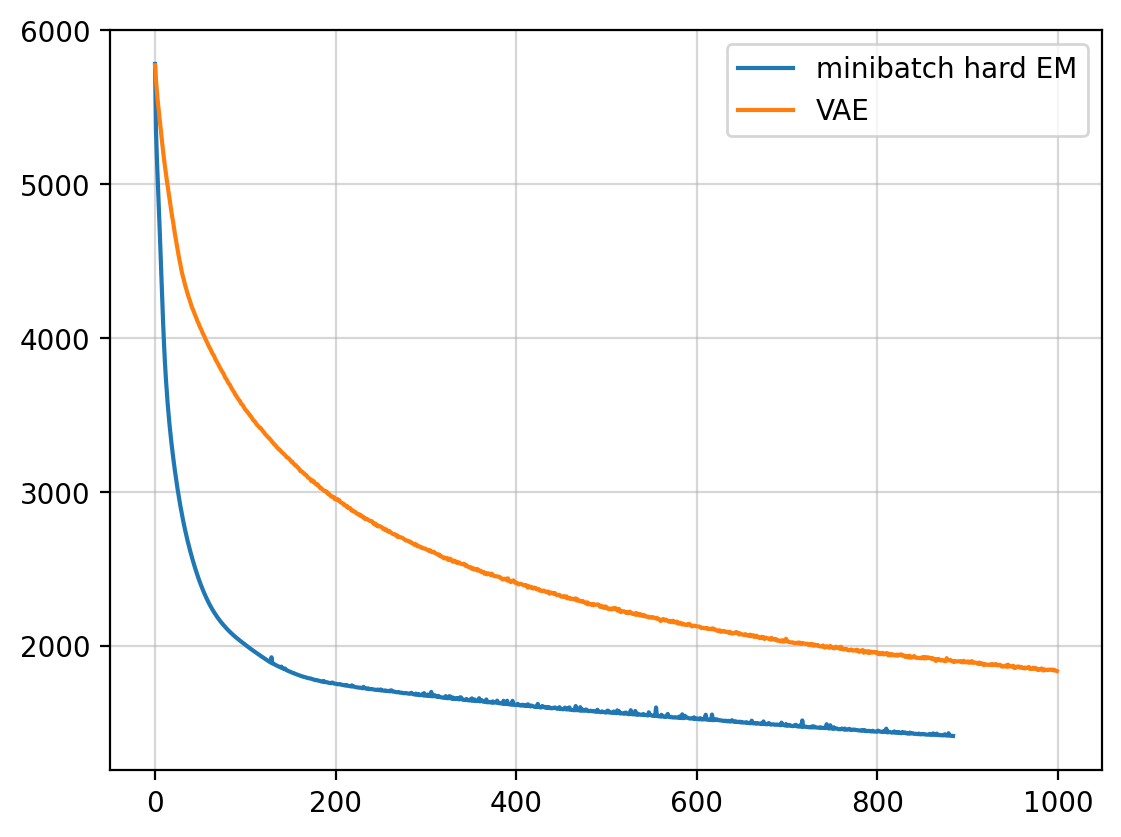

In [129]:
plt.plot(nll_hist, label="minibatch hard EM")
plt.plot(hist_vae_loss, label="VAE")
plt.legend()
# plt.xscale("log")
plt.grid(alpha=0.5)

## Minibatch

In [122]:
%%time

decoder = hlax.models.HomkDecoder(dim_obs, dim_latent)
lossfn = hlax.hard_decoder.loss_hard_nmll

tx_params = optax.adam(1e-3)
tx_latent = optax.adam(5e-4)

key_init, key_step = jax.random.split(key_train)

states = hlax.hard_decoder.initialise_state(key, decoder, tx_params,
                                            tx_latent, X_train, dim_latent)
opt_states, target_states = states
params_decoder, z_decoder = target_states

 
n_its_params, n_its_latent = 20, 50
nll_hist = []
for e in tqdm(range(n_epochs)):
    res = hlax.hard_decoder.train_epoch(key_step, params_decoder, z_decoder,
                                        opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                        n_its_params, n_its_latent, lossfn)
    nll, params_decoder, z_decoder, opt_states = res
    nll_hist.append(nll)
    print(f"{nll:0.4e}", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12.5 s, sys: 2.94 s, total: 15.4 s
Wall time: 13.2 s


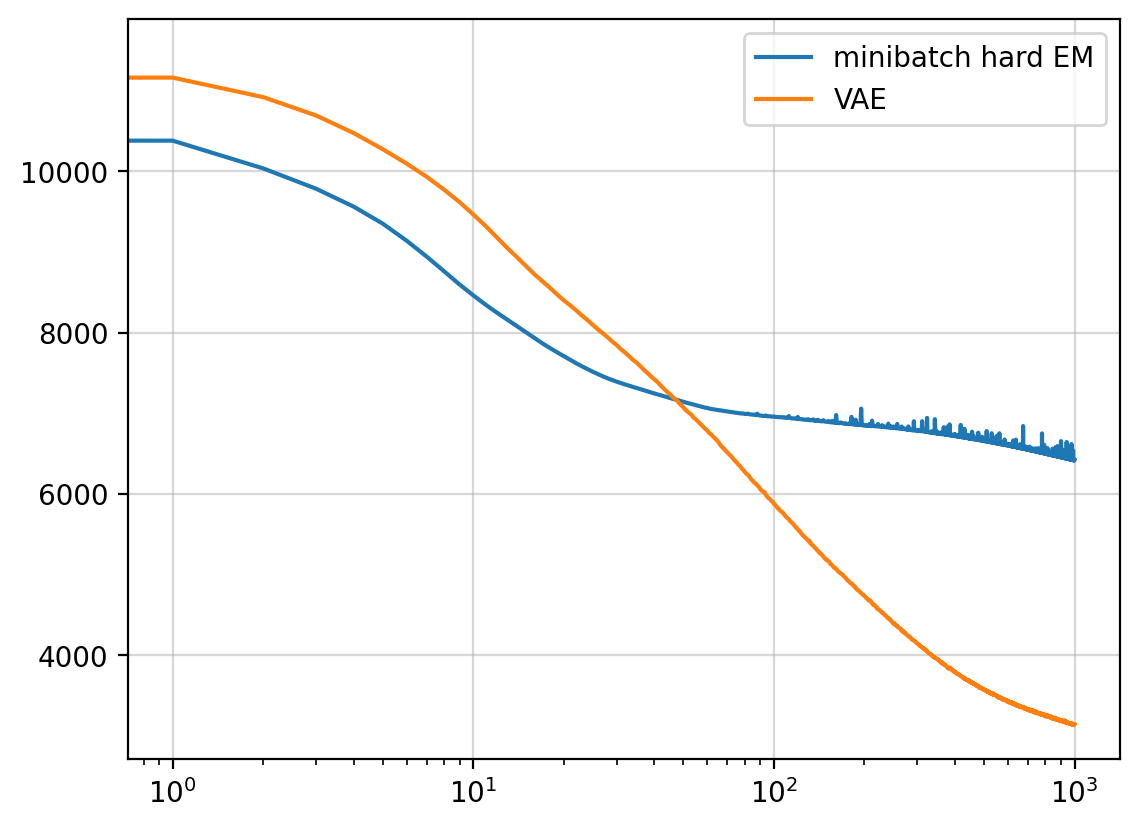

In [28]:
plt.plot(nll_hist, label="minibatch hard EM")
plt.plot(hist_vae_loss, label="VAE")
plt.legend()
plt.xscale("log")
plt.grid(alpha=0.5)

# ymin, _ = plt.ylim()
# ymax = min(max(nll_hist), max(hist_vae_loss))
# ymin = min(min(nll_hist), min(hist_vae_loss))
# plt.ylim(ymin, ymax)

## Multiple runs

In [60]:
from itertools import product
from time import time

In [61]:
import pandas as pd
import numpy as np

In [62]:
%%time
N_its_params = range(1, 11, 2)
N_its_latent = range(1, 31, 2)

dict_res = {}
for (n_its_params, n_its_latent) in product(N_its_params, N_its_latent):
    nll_hist = []
    str_name = f"p{n_its_params:02}-l{n_its_latent:02}"
    print(f"Training {str_name}")
    
    opt_states, target_states = hlax.hard_decoder.initialise_state(key, decoder, tx_params, tx_latent, X_train, dim_latent)
    params_decoder, z_decoder = target_states

    
    time_init = time()
    for e in tqdm(range(n_epochs), leave=False):
        res = hlax.hard_decoder.train_epoch(key_step, params_decoder, z_decoder,
                                            opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                            n_its_params, n_its_latent, lossfn)
        nll, params_decoder, z_decoder, opt_states = res
        nll_hist.append(nll)
    
    time_end = time()
    time_total = time_end -  time_init
    dict_res[str_name] = {
        "nll_hist": nll_hist,
        "time": time_total
    }


dict_nll = {key: np.array(dict_res[key]["nll_hist"]) for key in dict_res}
df_nll = pd.DataFrame(dict_nll)
df_nll.head()

Training p01-l01


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l03


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l05


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l07


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l09


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l11


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l13


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l15


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l17


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l19


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l21


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l23


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l25


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l27


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p01-l29


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l01


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l03


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l05


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l07


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l09


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l11


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l13


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l15


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l17


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l19


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l21


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l23


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l25


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l27


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p03-l29


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l01


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l03


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l05


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l07


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l09


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l11


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l13


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l15


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l17


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l19


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l21


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l23


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l25


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l27


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p05-l29


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l01


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l03


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l05


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l07


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l09


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l11


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l13


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l15


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l17


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l19


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l21


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l23


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l25


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l27


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p07-l29


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l01


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l03


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l05


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l07


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l09


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l11


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l13


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l15


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l17


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l19


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l21


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l23


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l25


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l27


  0%|          | 0/1000 [00:00<?, ?it/s]

Training p09-l29


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1h 17min 8s, sys: 15min 21s, total: 1h 32min 30s
Wall time: 46min 17s


,p01-l01,p01-l03,p01-l05,p01-l07,p01-l09,p01-l11,p01-l13,p01-l15,p01-l17,p01-l19,...,p09-l11,p09-l13,p09-l15,p09-l17,p09-l19,p09-l21,p09-l23,p09-l25,p09-l27,p09-l29
0,4032200.00,3964642.50,3906533.75,3856592.75,3813499.75,3776276.00,3744077.00,3716233.5,3691916.00,3670775.25,...,3529051.75,3510800.00,3494342.50,3479323.0,3465814.50,3453792.25,3442998.50,3433332.50,3424818.0,3417081.25
1,3884255.00,3792090.75,3722471.25,3669662.25,3629319.25,3598384.50,3574488.75,3555869.5,3541126.00,3529437.50,...,3262492.25,3243357.50,3225458.00,3208417.5,3192826.00,3178317.25,3164635.00,3151998.00,3139915.0,3128021.50
2,3770421.25,3673179.25,3607528.00,3563043.50,3532513.25,3511343.00,3496290.75,3485331.0,3477143.25,3470886.00,...,3113292.25,3084520.25,3057578.75,3031156.5,3006907.25,2983445.25,2961160.75,2941453.25,2922451.5,2904900.50
3,3681982.25,3587565.00,3530001.50,3494731.00,3472569.75,3458152.25,3448249.00,3441081.5,3435651.00,3431334.25,...,2971705.75,2926847.00,2883302.75,2845490.0,2816304.50,2792065.50,2770933.50,2753959.25,2738200.0,2725466.00
4,3612283.00,3523316.25,3473567.50,3445456.00,3428627.50,3417648.50,3409879.75,3403851.0,3398979.00,3394708.50,...,2810114.50,2755427.25,2715233.75,2686292.5,2664140.75,2645784.00,2629688.50,2616810.50,2604238.0,2595905.00


In [71]:
df_nll["p07-l29"]

0      3.458224e+06
1      3.203096e+06
2      3.013580e+06
3      2.845992e+06
4      2.714904e+06
           ...     
995    6.826005e+05
996    6.821951e+05
997    6.810489e+05
998    6.805033e+05
999    6.868951e+05
Name: p07-l29, Length: 1000, dtype: float32

In [ ]:
df_nll["p09-l25"].plot()
plt.plot(hist_vae_loss, label="VAE")
plt.xscale("log")
plt.grid(alpha=0.5)
plt.legend()

## Analysing results

## Analysing posterior observations

In [93]:
def clean_axis(ax):
    """
    Source
    https://stackoverflow.com/questions/49155654
    """
    # make xaxis invisibel
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)


In [94]:
n_samples = 8
key_choice, keys_is = jax.random.split(key_samples)
keys_is = jax.random.split(keys_is, n_samples)

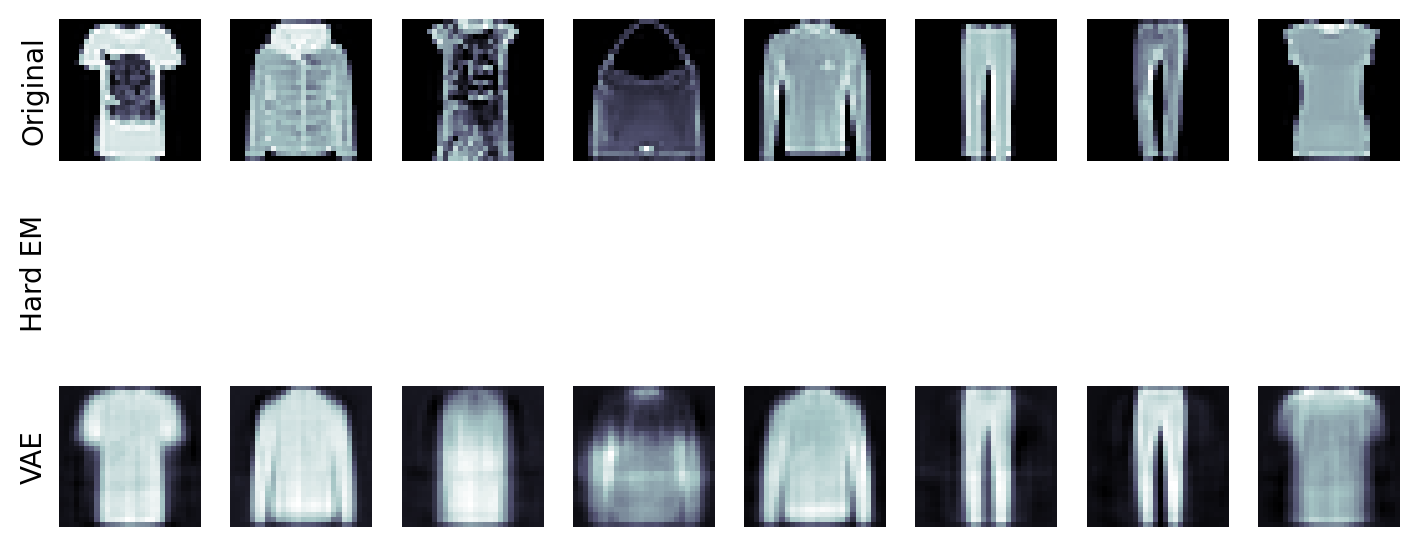

In [95]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, axs = plt.subplots(3, n_samples, figsize=(7, 3.0))

cmap = "bone"
for ax, ix, key in zip(axs.T, ixs_test, keys_is):
    obs = X_train[ix]
    mean_x, var_x = decoder.apply(params_decoder, z_decoder[ix])
    _, _, (mean_x_vae, logvar_x_vae) = model.apply(params_vae, obs, key)
    

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x.reshape(28, 28), cmap=cmap)
    ax[2].imshow(mean_x_vae.reshape(28, 28), cmap=cmap)
    
    for axi in ax:
        clean_axis(axi)
        
plt.tight_layout()

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Hard EM")
axs[2, 0].set_ylabel("VAE");